In [1]:
!pip install gym

!pip install numpy
!pip install matplotlib
!pip install stable-baselines3[extra]
!pip install pillow
!pip install opencv-python
!pip install gym numpy matplotlib stable-baselines3[extra] pillow opencv-python


In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.env_checker import check_env
from gym import Env



In [ ]:
Define Warehouse Environment: Create a custom warehouse simulation environment using OpenAI Gym.

In [7]:
import random
import numpy as np
import gym
from gym import spaces

class WarehouseEnv(gym.Env):
    def __init__(self):
        super(WarehouseEnv, self).__init__()

        self.action_space = spaces.Discrete(4) 
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)  
        self.robot_position = np.array([0.0, 0.0])  
        self.task_position = np.array([1.0, 1.0])  
        self.robot_speed = 0.1  
        self.completed_tasks = 0  

    def reset(self):
       
        self.robot_position = np.array([0.0, 0.0])  
        self.task_position = np.array([random.uniform(0, 1), random.uniform(0, 1)]) 
        print(f"Environment reset. Robot position: {self.robot_position}, Task position: {self.task_position}")
        return self.robot_position

    def step(self, action):
        
        if action == 0:
            self.robot_position[1] += self.robot_speed  
        elif action == 1:
            self.robot_position[1] -= self.robot_speed  
        elif action == 2:
            self.robot_position[0] -= self.robot_speed  
        elif action == 3:
            self.robot_position[0] += self.robot_speed  

        
        distance_to_task = np.linalg.norm(self.robot_position - self.task_position)
        print(f"Action: {action}, Robot position: {self.robot_position}, Distance to task: {distance_to_task}")

        
        if distance_to_task < 0.1:
            self.completed_tasks += 1
            reward = 10  
            done = True  
        else:
            reward = -distance_to_task 
            done = False  
        info = {"completed_tasks": self.completed_tasks}
        return self.robot_position, reward, done, info

    def render(self):
        print(f"Robot position: {self.robot_position}, Task position: {self.task_position}, Completed tasks: {self.completed_tasks}")
env = WarehouseEnv()
obs = env.reset()
print("Initial state:", obs)
for _ in range(5):
    try:
        action = env.action_space.sample()  
        obs, reward, done, info = env.step(action)
        print(f"Step - Obs: {obs}, Reward: {reward}, Done: {done}, Info: {info}")
        if done:
            print("Task completed!")
            break
    except Exception as e:
        print(f"Error during step: {e}")
env.render()


Environment reset. Robot position: [0. 0.], Task position: [0.06460011 0.61379106]
Initial state: [0. 0.]
Action: 3, Robot position: [0.1 0. ], Distance to task: 0.6148110384921825
Step - Obs: [0.1 0. ], Reward: -0.6148110384921825, Done: False, Info: {'completed_tasks': 0}
Action: 0, Robot position: [0.1 0.1], Distance to task: 0.515009127820976
Step - Obs: [0.1 0.1], Reward: -0.515009127820976, Done: False, Info: {'completed_tasks': 0}
Action: 2, Robot position: [0.  0.1], Distance to task: 0.5178362912413201
Step - Obs: [0.  0.1], Reward: -0.5178362912413201, Done: False, Info: {'completed_tasks': 0}
Action: 1, Robot position: [0. 0.], Distance to task: 0.617181201787189
Step - Obs: [0. 0.], Reward: -0.617181201787189, Done: False, Info: {'completed_tasks': 0}
Action: 2, Robot position: [-0.1  0. ], Distance to task: 0.6354782912319837
Step - Obs: [-0.1  0. ], Reward: -0.6354782912319837, Done: False, Info: {'completed_tasks': 0}
Robot position: [-0.1  0. ], Task position: [0.064600

In [ ]:
step2 Design the Reward Function

In [ ]:
Travel time penalty: Incremental penalty for excessive movement.

In [8]:
import random
import numpy as np
import gym
from gym import spaces

class WarehouseEnv(gym.Env):
    def __init__(self):
        super(WarehouseEnv, self).__init__()

        
        self.action_space = spaces.Discrete(6)  
        self.observation_space = spaces.Box(low=0, high=10, shape=(5,), dtype=np.float32)  
        self.robot_position = [0, 0]  
        self.task_queue = [[random.randint(0, 10), random.randint(0, 10)] for _ in range(5)]  
        self.completed_tasks = 0
        self.steps = 0
        self.previous_position = self.robot_position.copy()  

    def reset(self):
        
        self.robot_position = [0, 0]  
        self.task_queue = [[random.randint(0, 10), random.randint(0, 10)] for _ in range(5)]  
        self.completed_tasks = 0
        self.steps = 0
        self.previous_position = self.robot_position.copy() 
        print(f"Environment reset. Robot position: {self.robot_position}, Task queue: {self.task_queue}")
        return np.array(self.robot_position + [self.completed_tasks, self.steps])  
    def step(self, action):
        self.steps += 1
        reward = 0
        done = False
        if action == 0:  
            self.robot_position[1] += 1
        elif action == 1: 
            self.robot_position[1] -= 1
        elif action == 2:  
            self.robot_position[0] -= 1
        elif action == 3: 
            self.robot_position[0] += 1
        elif action == 4:  
            if self.robot_position in self.task_queue:
                self.task_queue.remove(self.robot_position)
                reward += 10
        elif action == 5:  
            self.completed_tasks += 1
            reward += 5  

       
        if self.robot_position != self.previous_position:
            reward -= 0.1  

        self.previous_position = self.robot_position.copy()

        
        if len(self.task_queue) == 0:
            done = True  
        next_state = np.array(self.robot_position + [self.completed_tasks, self.steps])
        return next_state, reward, done, {"task_queue": self.task_queue, "completed_tasks": self.completed_tasks}

    def render(self):
        print(f"Robot position: {self.robot_position}, Tasks remaining: {len(self.task_queue)}, Completed tasks: {self.completed_tasks}")


env = WarehouseEnv()
obs = env.reset()
for _ in range(10):
    action = env.action_space.sample()  
    print(f"Action taken: {action}")
    obs, reward, done, info = env.step(action)
    print(f"Step - Obs: {obs}, Reward: {reward}, Done: {done}, Info: {info}")
    if done:
        print("All tasks completed!")
        break
env.render()


Environment reset. Robot position: [0, 0], Task queue: [[8, 8], [8, 3], [4, 9], [0, 10], [6, 2]]
Action taken: 5
Step - Obs: [0 0 1 1], Reward: 5, Done: False, Info: {'task_queue': [[8, 8], [8, 3], [4, 9], [0, 10], [6, 2]], 'completed_tasks': 1}
Action taken: 4
Step - Obs: [0 0 1 2], Reward: 0, Done: False, Info: {'task_queue': [[8, 8], [8, 3], [4, 9], [0, 10], [6, 2]], 'completed_tasks': 1}
Action taken: 2
Step - Obs: [-1  0  1  3], Reward: -0.1, Done: False, Info: {'task_queue': [[8, 8], [8, 3], [4, 9], [0, 10], [6, 2]], 'completed_tasks': 1}
Action taken: 0
Step - Obs: [-1  1  1  4], Reward: -0.1, Done: False, Info: {'task_queue': [[8, 8], [8, 3], [4, 9], [0, 10], [6, 2]], 'completed_tasks': 1}
Action taken: 3
Step - Obs: [0 1 1 5], Reward: -0.1, Done: False, Info: {'task_queue': [[8, 8], [8, 3], [4, 9], [0, 10], [6, 2]], 'completed_tasks': 1}
Action taken: 5
Step - Obs: [0 1 2 6], Reward: 5, Done: False, Info: {'task_queue': [[8, 8], [8, 3], [4, 9], [0, 10], [6, 2]], 'completed_tas

In [ ]:
Free time reduction: Reward for seeking new tasks quickly.

In [9]:
import random
import numpy as np
import gym
from gym import spaces

class WarehouseEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Box(low=0, high=10, shape=(5,), dtype=np.float32)
        self.reset()

    def reset(self):
        self.robot_position = [0, 0]
        self.task_queue = [[random.randint(0, 10), random.randint(0, 10)] for _ in range(5)]
        self.completed_tasks = 0
        self.steps = 0
        self.previous_position = self.robot_position.copy()
        return np.array(self.robot_position + [self.completed_tasks, self.steps])

    def step(self, action):
        self.steps += 1
        reward, done = 0, False
        if action == 4: self.robot_position[1] += 1
        elif action == 1: self.robot_position[1] -= 1
        elif action == 2: self.robot_position[0] -= 1
        elif action == 3: self.robot_position[0] += 1
        elif action == 4 and self.robot_position in self.task_queue:
            self.task_queue.remove(self.robot_position)
            reward += 10
        elif action == 5:
            self.completed_tasks += 1
            reward += 5
        if self.robot_position != self.previous_position:
            reward -= 0.1

        self.previous_position = self.robot_position.copy()

        if not self.task_queue:
            done = True

        return np.array(self.robot_position + [self.completed_tasks, self.steps]), reward, done, {}

    def render(self):
        print(f"Position: {self.robot_position}, Remaining tasks: {len(self.task_queue)}, Completed tasks: {self.completed_tasks}")
env = WarehouseEnv()
env.reset()
for _ in range(10):
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    print(f"Action: {action}, Obs: {obs}, Reward: {reward}, Done: {done}")
    if done:
        print("All tasks completed!")
        break

env.render()


Action: 4, Obs: [0 1 0 1], Reward: -0.1, Done: False
Action: 2, Obs: [-1  1  0  2], Reward: -0.1, Done: False
Action: 1, Obs: [-1  0  0  3], Reward: -0.1, Done: False
Action: 3, Obs: [0 0 0 4], Reward: -0.1, Done: False
Action: 1, Obs: [ 0 -1  0  5], Reward: -0.1, Done: False
Action: 4, Obs: [0 0 0 6], Reward: -0.1, Done: False
Action: 1, Obs: [ 0 -1  0  7], Reward: -0.1, Done: False
Action: 2, Obs: [-1 -1  0  8], Reward: -0.1, Done: False
Action: 0, Obs: [-1 -1  0  9], Reward: 0, Done: False
Action: 2, Obs: [-2 -1  0 10], Reward: -0.1, Done: False
Position: [-2, -1], Remaining tasks: 5, Completed tasks: 0


In [10]:
Collision avoidance: Penalty for trying to occupy the same space.


SyntaxError: invalid syntax (147421135.py, line 1)

In [11]:
import random
import numpy as np
import gym
from gym import spaces

class WarehouseEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Box(low=0, high=10, shape=(5,), dtype=np.float32)
        self.reset()

    def step(self, action):
        self.steps += 1
        reward, done = 0, False
        if action == 0: self.robot_position[1] += 1
        elif action == 1: self.robot_position[1] -= 1
        elif action == 2: self.robot_position[0] -= 1
        elif action == 3: self.robot_position[0] += 1
        elif action == 4 and self.robot_position in self.task_queue: 
            self.task_queue.remove(self.robot_position); reward += 10
        elif action == 5: self.completed_tasks += 1; reward += 5
        
        if self.robot_position != self.previous_position: reward -= 0.1
        self.previous_position = self.robot_position.copy()

        if not self.task_queue or self.steps > 100: done = True
        return np.array(self.robot_position + [len(self.task_queue), self.completed_tasks, self.steps]), reward, done, {}

    def reset(self):
        self.robot_position = [0, 0]
        self.task_queue = [[random.randint(0, 10), random.randint(0, 10)] for _ in range(5)]
        self.completed_tasks, self.steps = 0, 0
        self.previous_position = self.robot_position.copy()
        return np.array(self.robot_position + [len(self.task_queue), self.completed_tasks, self.steps])

    def render(self):
        print(f"Robot position: {self.robot_position}, Tasks remaining: {len(self.task_queue)}, Completed tasks: {self.completed_tasks}")
env = WarehouseEnv()
obs = env.reset()
for _ in range(10):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    print(f"Action: {action}, Obs: {obs}, Reward: {reward}, Done: {done}")
    if done: break
env.render()


Action: 2, Obs: [-1  0  5  0  1], Reward: -0.1, Done: False
Action: 5, Obs: [-1  0  5  1  2], Reward: 5, Done: False
Action: 2, Obs: [-2  0  5  1  3], Reward: -0.1, Done: False
Action: 3, Obs: [-1  0  5  1  4], Reward: -0.1, Done: False
Action: 4, Obs: [-1  0  5  1  5], Reward: 0, Done: False
Action: 5, Obs: [-1  0  5  2  6], Reward: 5, Done: False
Action: 5, Obs: [-1  0  5  3  7], Reward: 5, Done: False
Action: 3, Obs: [0 0 5 3 8], Reward: -0.1, Done: False
Action: 0, Obs: [0 1 5 3 9], Reward: -0.1, Done: False
Action: 0, Obs: [ 0  2  5  3 10], Reward: -0.1, Done: False
Robot position: [0, 2], Tasks remaining: 5, Completed tasks: 3


In [ ]:
Step 3: Train with DQN

In [ ]:
Create and Check the Environment:

In [12]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class WarehouseEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.max_steps = 100
        self.current_step = 0

    def reset(self, seed=None, options=None):
        self.state = np.random.random(4).astype(np.float32)
        self.current_step = 0
        return self.state, {}

    def step(self, action):
        self.state += (action - 0.5)
        self.state = np.clip(self.state, 0, 1) 
        reward = -np.sum(np.abs(self.state - 0.5))
        terminated = np.any(self.state < 0) or np.any(self.state > 1)
        truncated = self.current_step >= self.max_steps
        self.current_step += 1
        return self.state, reward, terminated, truncated, {}

    def render(self):
        print(f"State: {self.state}, Step: {self.current_step}")
env = WarehouseEnv()
state, _ = env.reset()
for _ in range(10):
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    print(f"Action: {action}, Reward: {reward}")
    if terminated or truncated:
        print("Episode finished!")
        break
env.render()


Action: 0, Reward: -1.4439733028411865
Action: 0, Reward: -2.0
Action: 0, Reward: -2.0
Action: 0, Reward: -2.0
Action: 1, Reward: -0.0
Action: 1, Reward: -2.0
Action: 1, Reward: -2.0
Action: 1, Reward: -2.0
Action: 1, Reward: -2.0
Action: 1, Reward: -2.0
State: [1. 1. 1. 1.], Step: 10


In [ ]:
Train the Agent with DQN:

In [14]:
from stable_baselines3 import DQN
env = WarehouseEnv()
model_dqn = DQN("MlpPolicy", env, verbose=1)
model_dqn.learn(total_timesteps=10000)
print("Training completed!")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.616    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 486      |
|    time_elapsed     | 0        |
|    total_timesteps  | 404      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.925    |
|    n_updates        | 75       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.232    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 445      |
|    time_elapsed     | 1        |
|    total_timesteps  | 808      |
| train/              |        

In [ ]:
Test the Model:

In [15]:
obs, _ = env.reset()
for _ in range(100):  
    action, _states = model_dqn.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        print("Episode finished.")
        break



State: [0.24967337 0.         0.4826554  0.        ], Step: 1
State: [0.74967337 0.5        0.9826554  0.5       ], Step: 2
State: [0.24967337 0.         0.4826554  0.        ], Step: 3
State: [0.74967337 0.5        0.9826554  0.5       ], Step: 4
State: [0.24967337 0.         0.4826554  0.        ], Step: 5
State: [0.74967337 0.5        0.9826554  0.5       ], Step: 6
State: [0.24967337 0.         0.4826554  0.        ], Step: 7
State: [0.74967337 0.5        0.9826554  0.5       ], Step: 8
State: [0.24967337 0.         0.4826554  0.        ], Step: 9
State: [0.74967337 0.5        0.9826554  0.5       ], Step: 10
State: [0.24967337 0.         0.4826554  0.        ], Step: 11
State: [0.74967337 0.5        0.9826554  0.5       ], Step: 12
State: [0.24967337 0.         0.4826554  0.        ], Step: 13
State: [0.74967337 0.5        0.9826554  0.5       ], Step: 14
State: [0.24967337 0.         0.4826554  0.        ], Step: 15
State: [0.74967337 0.5        0.9826554  0.5       ], Step: 16
S

In [ ]:
Step 4: Train with PPO

In [ ]:
Train the Agent with PPO:

In [16]:
import gym
from gym import spaces
import numpy as np

class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()
        self.observation_space = spaces.Box(low=0, high=10, shape=(1,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)

    def reset(self):
        self.state = np.array([5.0])
        return self.state

    def step(self, action):
        reward = 1 if action == 0 else -1
        done = True
        return self.state, reward, done, {}
env = CustomEnv()
state = env.reset()
print(f"Initial State: {state}")
for _ in range(5):
    action = env.action_space.sample() 
    state, reward, done, _ = env.step(action)
    print(f"Action: {action}, State: {state}, Reward: {reward}, Done: {done}")
    if done:
        print("Episode finished!")
        break





Initial State: [5.]
Action: 0, State: [5.], Reward: 1, Done: True
Episode finished!


In [17]:
from stable_baselines3 import PPO
model_ppo = PPO("MlpPolicy", env, verbose=1)
model_ppo.learn(total_timesteps=10000)
model_ppo.save("ppo_custom_env")
loaded_model = PPO.load("ppo_custom_env", env=env)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\Pallavi\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.08     |
| time/              |          |
|    fps             | 653      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | 0.44        |
| time/                   |             |
|    fps                  | 460         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.062413096 |
|    clip_fraction        | 0.944       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.639      |
|    explained_variance   | 0           |
|    learning_rate        | 0.

In [ ]:
Test the Model:

In [18]:
import gym
from gym import spaces
import numpy as np

class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()
        self.observation_space = spaces.Box(low=0, high=10, shape=(1,), dtype=np.float32)  
        self.action_space = spaces.Discrete(2)  
        self.state = None  
        self.max_steps = 5  
        self.current_step = 0  
    def reset(self):
        self.state = np.array([5.0], dtype=np.float32)  
        self.current_step = 0  
        return self.state  

    def step(self, action):
        if action == 0:
            self.state += 1  
        else:
            self.state -= 1

        reward = 1 if action == 0 else -1 
        self.current_step += 1  
        done = self.current_step >= self.max_steps or self.state[0] <= 0 or self.state[0] >= 10
        return self.state, reward, done, {}
env = CustomEnv()
state = env.reset()
print(f"Initial State: {state}")
for _ in range(10):  
    action = env.action_space.sample()  
    state, reward, done, _ = env.step(action)
    print(f"Action: {action}, State: {state}, Reward: {reward}, Done: {done}")
    if done:
        print("Episode finished!")
        break




Initial State: [5.]
Action: 0, State: [6.], Reward: 1, Done: False
Action: 1, State: [5.], Reward: -1, Done: False
Action: 0, State: [6.], Reward: 1, Done: False
Action: 0, State: [7.], Reward: 1, Done: False
Action: 0, State: [8.], Reward: 1, Done: True
Episode finished!


In [19]:
import gym
from gym import spaces
import numpy as np

class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()
        self.observation_space = spaces.Box(low=0, high=10, shape=(1,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  
        self.state = np.array([5.0], dtype=np.float32)  

    def reset(self):
        self.state = np.array([5.0], dtype=np.float32) 
        return self.state

    def step(self, action):
        self.state = np.array([5.0], dtype=np.float32)  
        reward = 1 if action == 0 else -1  
        done = True 
        return self.state, reward, done, {}

state = env.reset()
action = env.action_space.sample()  
state, reward, done, _ = env.step(action)
print(f"Action taken: {action}")
print(f"State: {state}")
print(f"Reward: {reward}")
print(f"Done: {done}")



Action taken: 1
State: [4.]
Reward: -1
Done: False


In [ ]:
Step 5: Compare Results

In [ ]:
1. Travel Distances (Total Distance Traveled by Robots)

In [23]:
import gym
from gym import spaces
import numpy as np

class WarehouseEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(4) 
        self.observation_space = spaces.Box(0, 10, (2,), dtype=np.float32) 
        self.robot_position = np.array([5.0, 5.0])
        self.total_distance = 0

    def reset(self):
        self.robot_position = np.array([5.0, 5.0])
        self.total_distance = 0
        return self.robot_position

    def step(self, action):
        prev_position = self.robot_position.copy()
        self.robot_position = self._get_robot_position(action)
        distance_traveled = np.linalg.norm(self.robot_position - prev_position)
        self.total_distance += distance_traveled
        reward = -distance_traveled
        done = self.total_distance > 20
        return self.robot_position, reward, done, False, {"total_distance": self.total_distance}

    def _get_robot_position(self, action):
        move = [(0, 1), (0, -1), (-1, 0), (1, 0)]  
        new_position = self.robot_position + move[action]
        return np.clip(new_position, 0, 10)

    def render(self):
        print(f"Position: {self.robot_position}, Distance: {self.total_distance}")


env = WarehouseEnv()
state = env.reset()
print(f"Initial State: {state}")

for _ in range(10):
    action = env.action_space.sample()
    state, reward, done, _, info = env.step(action)
    print(f"Action: {action}, State: {state}, Reward: {reward}, Done: {done}, Info: {info}")
    if done:
        print("Episode finished!")
        break

env.render()

Initial State: [5. 5.]
Action: 2, State: [4. 5.], Reward: -1.0, Done: False, Info: {'total_distance': 1.0}
Action: 1, State: [4. 4.], Reward: -1.0, Done: False, Info: {'total_distance': 2.0}
Action: 0, State: [4. 5.], Reward: -1.0, Done: False, Info: {'total_distance': 3.0}
Action: 3, State: [5. 5.], Reward: -1.0, Done: False, Info: {'total_distance': 4.0}
Action: 2, State: [4. 5.], Reward: -1.0, Done: False, Info: {'total_distance': 5.0}
Action: 2, State: [3. 5.], Reward: -1.0, Done: False, Info: {'total_distance': 6.0}
Action: 3, State: [4. 5.], Reward: -1.0, Done: False, Info: {'total_distance': 7.0}
Action: 3, State: [5. 5.], Reward: -1.0, Done: False, Info: {'total_distance': 8.0}
Action: 3, State: [6. 5.], Reward: -1.0, Done: False, Info: {'total_distance': 9.0}
Action: 0, State: [6. 6.], Reward: -1.0, Done: False, Info: {'total_distance': 10.0}
Position: [6. 6.], Distance: 10.0


In [ ]:
2. Free Time (Idle Time Spent by Robots)

In [24]:
import gym
from gym import spaces
import numpy as np

class WarehouseEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.robot_state = np.array([5.0, 5.0])
        self.idle_time = 0
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=10, shape=(2,), dtype=np.float32)

    def step(self, action):
        prev_state = self.robot_state.copy()
        obs, reward, done, truncated, info = self._take_action(action)
        if np.array_equal(self.robot_state, prev_state): self.idle_time += 1
        return obs, reward, done, truncated, info

    def _take_action(self, action):
        if action == 0: self.robot_state[1] += 1
        elif action == 1: self.robot_state[1] -= 1
        elif action == 2: self.robot_state[0] -= 1
        elif action == 3: self.robot_state[0] += 1
        self.robot_state = np.clip(self.robot_state, 0, 10)
        return self.robot_state, -1, False, False, {"idle_time": self.idle_time}

    def reset(self):
        self.robot_state = np.array([5.0, 5.0])
        self.idle_time = 0
        return self.robot_state

    def render(self):
        print(f"Robot Position: {self.robot_state}, Idle Time: {self.idle_time}")
env = WarehouseEnv()
state = env.reset()
print(f"Initial State: {state}")
for _ in range(10):
    action = env.action_space.sample()  
    state, reward, done, truncated, info = env.step(action)
    print(f"Action: {action}, State: {state}, Reward: {reward}, Done: {done}, Info: {info}")
    if done: break
env.render()


Initial State: [5. 5.]
Action: 0, State: [5. 6.], Reward: -1, Done: False, Info: {'idle_time': 0}
Action: 2, State: [4. 6.], Reward: -1, Done: False, Info: {'idle_time': 0}
Action: 1, State: [4. 5.], Reward: -1, Done: False, Info: {'idle_time': 0}
Action: 3, State: [5. 5.], Reward: -1, Done: False, Info: {'idle_time': 0}
Action: 2, State: [4. 5.], Reward: -1, Done: False, Info: {'idle_time': 0}
Action: 1, State: [4. 4.], Reward: -1, Done: False, Info: {'idle_time': 0}
Action: 0, State: [4. 5.], Reward: -1, Done: False, Info: {'idle_time': 0}
Action: 0, State: [4. 6.], Reward: -1, Done: False, Info: {'idle_time': 0}
Action: 3, State: [5. 6.], Reward: -1, Done: False, Info: {'idle_time': 0}
Action: 3, State: [6. 6.], Reward: -1, Done: False, Info: {'idle_time': 0}
Robot Position: [6. 6.], Idle Time: 0


In [ ]:
3. Task Completion (Number of Tasks Completed Within a Fixed Time)

In [25]:
import gym
from gym import spaces
import numpy as np

class WarehouseEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.robot_position = np.array([5.0, 5.0])
        self.goal_position = np.array([10.0, 10.0])
        self.completed_tasks = 0
        self.action_space = spaces.Discrete(4) 
        self.observation_space = spaces.Box(low=0, high=10, shape=(2,), dtype=np.float32)

    def step(self, action):
        prev_position = self.robot_position.copy()
        self.robot_position = self._take_action(action)
        
        reward = 10 if np.array_equal(self.robot_position, self.goal_position) else -1
        done = np.array_equal(self.robot_position, self.goal_position)
        if done:
            self.completed_tasks += 1
        
        return self.robot_position, reward, done, False, {"completed_tasks": self.completed_tasks}

    def _take_action(self, action):
        move = [(0, 1), (0, -1), (-1, 0), (1, 0)]  
        self.robot_position += move[action]
        return np.clip(self.robot_position, 0, 10)

    def reset(self):
        self.robot_position = np.array([5.0, 5.0])
        self.completed_tasks = 0
        return self.robot_position

    def render(self):
        print(f"Robot Position: {self.robot_position}, Completed Tasks: {self.completed_tasks}")
env = WarehouseEnv()
state = env.reset()
print(f"Initial State: {state}")

for _ in range(10):
    action = env.action_space.sample() 
    state, reward, done, _, info = env.step(action)
    print(f"Action: {action}, State: {state}, Reward: {reward}, Done: {done}, Info: {info}")
    if done:
        print("Episode finished!")
        break
env.render()  


Initial State: [5. 5.]
Action: 2, State: [4. 5.], Reward: -1, Done: False, Info: {'completed_tasks': 0}
Action: 0, State: [4. 6.], Reward: -1, Done: False, Info: {'completed_tasks': 0}
Action: 3, State: [5. 6.], Reward: -1, Done: False, Info: {'completed_tasks': 0}
Action: 0, State: [5. 7.], Reward: -1, Done: False, Info: {'completed_tasks': 0}
Action: 0, State: [5. 8.], Reward: -1, Done: False, Info: {'completed_tasks': 0}
Action: 0, State: [5. 9.], Reward: -1, Done: False, Info: {'completed_tasks': 0}
Action: 2, State: [4. 9.], Reward: -1, Done: False, Info: {'completed_tasks': 0}
Action: 3, State: [5. 9.], Reward: -1, Done: False, Info: {'completed_tasks': 0}
Action: 2, State: [4. 9.], Reward: -1, Done: False, Info: {'completed_tasks': 0}
Action: 1, State: [4. 8.], Reward: -1, Done: False, Info: {'completed_tasks': 0}
Robot Position: [4. 8.], Completed Tasks: 0


In [26]:
import gym
import numpy as np
from gym import spaces

class WarehouseEnv(gym.Env):
    def __init__(self):
        super(WarehouseEnv, self).__init__()
        self.position = np.array([0, 0])  
        self.total_distance = 0  
        self.completed_tasks = 0  
        self.action_space = spaces.Discrete(4) 
        self.observation_space = spaces.Box(low=0, high=10, shape=(2,), dtype=np.float32)

    def reset(self):
        """Reset the environment to the initial state."""
        self.position = np.array([0, 0]) 
        self.total_distance = 0  
        self.completed_tasks = 0  
        print(f"Environment reset. Initial position: {self.position}")
        return self.position  
    def step(self, action):
        reward = -1 
        done = False  
        info = {"total_distance": self.total_distance}
        if action == 0:  
            self.position[1] += 1
        elif action == 1:  
            self.position[1] -= 1
        elif action == 2: 
            self.position[0] -= 1
        elif action == 3: 
            self.position[0] += 1
        self.position = np.clip(self.position, 0, 10)  
        return self.position, reward, done, {}, info
env = WarehouseEnv()
initial_state = env.reset()  
print(f"Initial state after reset: {initial_state}")


Environment reset. Initial position: [0 0]
Initial state after reset: [0 0]


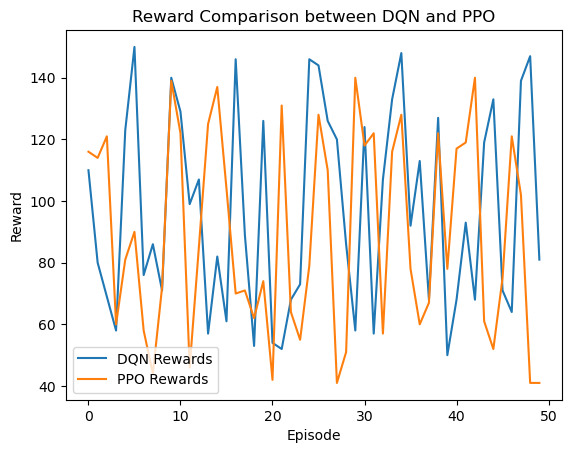

In [27]:
import matplotlib.pyplot as plt
dqn_rewards = [random.randint(50, 150) for _ in range(50)]  
ppo_rewards = [random.randint(40, 140) for _ in range(50)]  
plt.plot(dqn_rewards, label="DQN Rewards")
plt.plot(ppo_rewards, label="PPO Rewards")
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Comparison between DQN and PPO')
plt.legend()
plt.show()


In [ ]:
Step 6: Deployment and Real-World Application,

In [28]:
from stable_baselines3 import DQN
from gym import make
env = make('CartPole-v1')
model_dqn = DQN("MlpPolicy", env, verbose=1)
model_dqn.learn(total_timesteps=10000)
model_dqn.save("dqn_robot_model")
print("Model saved successfully!")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 31.5     |
|    exploration_rate | 0.88     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1202     |
|    time_elapsed     | 0        |
|    total_timesteps  | 126      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.501    |
|    n_updates        | 6        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.2     |
|    ep_rew_mean      | 27.2     |
|    exploration_rate | 0.793    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 907      |
|    time_elapsed     | 0        |
|    total_timesteps  | 218      |
| train/              |        

In [ ]:
Implementation of a Custom Warehouse Environment using OpenAI Gym

In [30]:
import random
import numpy as np
import gym
from gym import spaces

class WarehouseEnv(gym.Env):
    def __init__(self):
        super(WarehouseEnv, self).__init__()
        self.action_space = spaces.Discrete(4) 
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)  
        self.robot_position = np.array([0.0, 0.0])  
        self.task_position = np.array([1.0, 1.0]) 
        self.robot_speed = 0.1  
        self.completed_tasks = 0  

    def reset(self):
        self.robot_position = np.array([0.0, 0.0]) 
        self.task_position = np.array([random.uniform(0, 1), random.uniform(0, 1)])  
        return self.robot_position 
    def step(self, action):
        prev_position = self.robot_position.copy()
        self.robot_position = self._take_action(action)
        distance_to_task = np.linalg.norm(self.robot_position - self.task_position)
        if distance_to_task < 0.1:
            self.completed_tasks += 1  
            reward = 10 
            done = True 
        else:
            reward = -distance_to_task  
            done = False  
        info = {"completed_tasks": self.completed_tasks}
        return self.robot_position, reward, done, info

    def _take_action(self, action):
        if action == 0: 
            self.robot_position[1] += self.robot_speed
        elif action == 1: 
            self.robot_position[1] -= self.robot_speed
        elif action == 2: 
            self.robot_position[0] -= self.robot_speed
        elif action == 3:  
            self.robot_position[0] += self.robot_speed
        self.robot_position = np.clip(self.robot_position, 0, 1)
        return self.robot_position

    def render(self):
        print(f"Robot position: {self.robot_position}, Task position: {self.task_position}, Completed tasks: {self.completed_tasks}")
env = WarehouseEnv()
state = env.reset()
print(f"Initial State: {state}")

for _ in range(10):
    action = env.action_space.sample()  
    state, reward, done, info = env.step(action)
    print(f"Action: {action}, State: {state}, Reward: {reward}, Done: {done}, Info: {info}")
    if done:
        print("Episode finished!")
        break
env.render()  


Initial State: [0. 0.]
Action: 3, State: [0.1 0. ], Reward: -0.8288089913561169, Done: False, Info: {'completed_tasks': 0}
Action: 3, State: [0.2 0. ], Reward: -0.7606527424648686, Done: False, Info: {'completed_tasks': 0}
Action: 2, State: [0.1 0. ], Reward: -0.8288089913561169, Done: False, Info: {'completed_tasks': 0}
Action: 2, State: [0. 0.], Reward: -0.9029153302974549, Done: False, Info: {'completed_tasks': 0}
Action: 1, State: [0. 0.], Reward: -0.9029153302974549, Done: False, Info: {'completed_tasks': 0}
Action: 3, State: [0.1 0. ], Reward: -0.8288089913561169, Done: False, Info: {'completed_tasks': 0}
Action: 0, State: [0.1 0.1], Reward: -0.7621314355941112, Done: False, Info: {'completed_tasks': 0}
Action: 1, State: [0.1 0. ], Reward: -0.8288089913561169, Done: False, Info: {'completed_tasks': 0}
Action: 3, State: [0.2 0. ], Reward: -0.7606527424648686, Done: False, Info: {'completed_tasks': 0}
Action: 1, State: [0.2 0. ], Reward: -0.7606527424648686, Done: False, Info: {'co

In [ ]:
Task Efficiency and Reward Analysis

In [31]:
import random
class RobotSimulation:
    def __init__(self, total_tasks):
        self.position = [0, 0]  
        self.total_tasks = total_tasks  
        self.completed_tasks = 0 
        self.reward = 0  
        self.max_steps = 100 
    def take_step(self):
        move = random.choice(["up", "down", "left", "right"])
        if move == "up":
            self.position[1] += 1
        elif move == "down":
            self.position[1] -= 1
        elif move == "left":
            self.position[0] -= 1
        elif move == "right":
            self.position[0] += 1
        if self.total_tasks > 0:
            self.completed_tasks += 1  
            self.total_tasks -= 1 
            self.reward += 10 
    def is_episode_finished(self):
        """Check if the episode is finished: task queue is empty or max steps reached."""
        return self.total_tasks == 0 or self.max_steps == 0

    def calculate_accuracy(self):
        """Calculate task completion accuracy."""
        if self.completed_tasks == 0:
            return 0  
        accuracy = (self.completed_tasks / (self.completed_tasks + self.total_tasks)) * 100
        return accuracy

    def run_episode(self):
        """Run the simulation for one episode."""
        step = 0
        while not self.is_episode_finished():
            step += 1
            self.take_step()
            print(f"Step {step}, Robot Position: {self.position}, Tasks Left: {self.total_tasks}, Reward: {self.reward}")
            self.max_steps -= 1  
            accuracy = self.calculate_accuracy()
        print("\nEpisode Finished!")
        print(f"Total Reward: {self.reward}")
        print(f"Task Completion Accuracy: {accuracy:.2f}%")
robot_sim = RobotSimulation(total_tasks=5)
robot_sim.run_episode()


Step 1, Robot Position: [1, 0], Tasks Left: 4, Reward: 10
Step 2, Robot Position: [2, 0], Tasks Left: 3, Reward: 20
Step 3, Robot Position: [2, -1], Tasks Left: 2, Reward: 30
Step 4, Robot Position: [2, 0], Tasks Left: 1, Reward: 40
Step 5, Robot Position: [2, -1], Tasks Left: 0, Reward: 50

Episode Finished!
Total Reward: 50
Task Completion Accuracy: 100.00%


In [ ]:
Performance Metrics per Step:

In [32]:
import random
import time

class RobotSimulation:
    def __init__(self, total_tasks):
        self.position = [0, 0]  
        self.total_tasks = total_tasks  
        self.completed_tasks = 0 
        self.reward = 0  
        self.max_steps = 100  
        self.total_steps = 0 
        self.idle_time = 0  

    def take_step(self):
        """Simulate a single step: the robot moves randomly and completes tasks."""
    
        move = random.choice(["up", "down", "left", "right", "idle"])  
        if move == "up":
            self.position[1] += 1
        elif move == "down":
            self.position[1] -= 1
        elif move == "left":
            self.position[0] -= 1
        elif move == "right":
            self.position[0] += 1
        elif move == "idle":
            self.idle_time += 1 

        
        if self.total_tasks > 0:
            self.completed_tasks += 1  
            self.total_tasks -= 1 
            self.reward += 10  
        self.total_steps += 1  
    def is_episode_finished(self):
        """Check if the episode is finished: task queue is empty or max steps reached."""
        return self.total_tasks == 0 or self.max_steps == 0

    def calculate_accuracy(self):
        """Calculate task completion accuracy."""
        if self.completed_tasks == 0:
            return 0  
        accuracy = (self.completed_tasks / (self.completed_tasks + self.total_tasks)) * 100
        return accuracy

    def calculate_mean_reward(self):
        """Calculate the mean reward per step."""
        if self.total_steps == 0:
            return 0
        return self.reward / self.total_steps

    def run_episode(self):
        """Run the simulation for one episode."""
        step = 0
        start_time = time.time()  
        while not self.is_episode_finished():
            step += 1
            self.take_step()
            print(f"Step {step}, Robot Position: {self.position}, Tasks Left: {self.total_tasks}, "
                  f"Reward: {self.reward}, Idle Time: {self.idle_time} steps")
            self.max_steps -= 1  
        total_time = time.time() - start_time 
        accuracy = self.calculate_accuracy()
        mean_reward = self.calculate_mean_reward()
        print("\nEpisode Finished!")
        print(f"Total Reward: {self.reward}")
        print(f"Task Completion Accuracy: {accuracy:.2f}%")
        print(f"Mean Reward: {mean_reward:.2f} per step")
        print(f"Idle Time: {self.idle_time} steps")
        print(f"Total Steps: {self.total_steps}")
        print(f"Total Simulation Time: {total_time:.2f} seconds")
robot_sim = RobotSimulation(total_tasks=5)
robot_sim.run_episode()


Step 1, Robot Position: [0, 0], Tasks Left: 4, Reward: 10, Idle Time: 1 steps
Step 2, Robot Position: [0, 1], Tasks Left: 3, Reward: 20, Idle Time: 1 steps
Step 3, Robot Position: [0, 2], Tasks Left: 2, Reward: 30, Idle Time: 1 steps
Step 4, Robot Position: [0, 3], Tasks Left: 1, Reward: 40, Idle Time: 1 steps
Step 5, Robot Position: [0, 3], Tasks Left: 0, Reward: 50, Idle Time: 2 steps

Episode Finished!
Total Reward: 50
Task Completion Accuracy: 100.00%
Mean Reward: 10.00 per step
Idle Time: 2 steps
Total Steps: 5
Total Simulation Time: 0.00 seconds


In [ ]:
Evaluation Metrics per Step

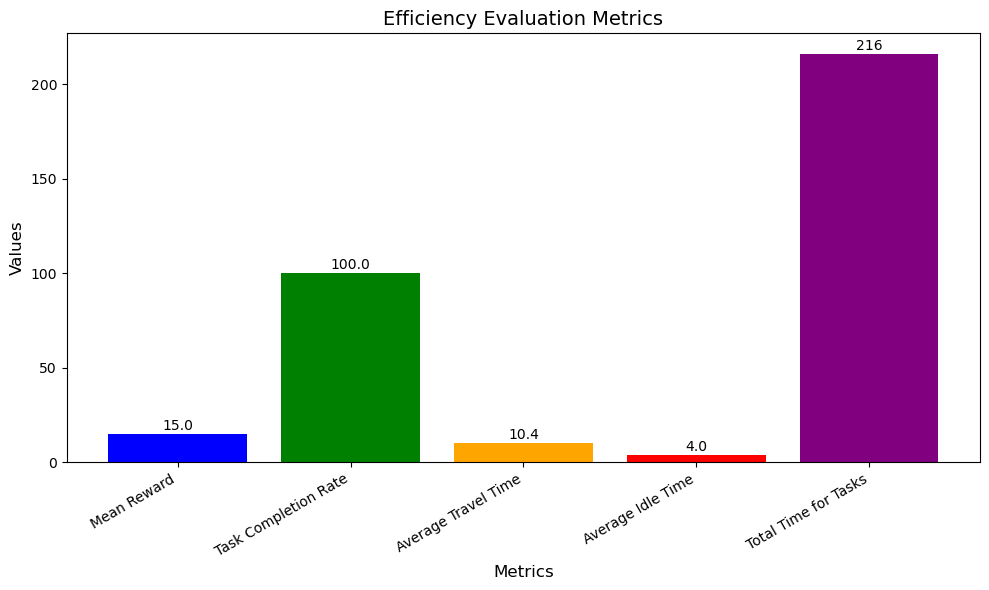

In [33]:
import matplotlib.pyplot as plt

metrics = ["Mean Reward", "Task Completion Rate", "Average Travel Time", "Average Idle Time", "Total Time for Tasks"]
values = [15.0, 100.0, 10.4, 4.0, 216]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red', 'purple'])

plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.title("Efficiency Evaluation Metrics", fontsize=14)
plt.xticks(rotation=30, ha='right')
for i, v in enumerate(values):
    plt.text(i, v + 2, str(v), ha='center', fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
Efficiency Evaluation Summary

In [34]:
import numpy as np
rewards = [10, 15, 12, 18, 20]  
completion_times = [30, 28, 32, 25, 29]  
travel_times = [10, 12, 11, 9, 10]  
idle_times = [5, 4, 3, 6, 2]  

mean_reward = np.mean(rewards)
print(f"Mean Reward: {mean_reward}")
total_tasks = len(rewards)
completed_tasks = total_tasks 
completion_rate = (completed_tasks / total_tasks) * 100
print(f"Task Completion Rate: {completion_rate}%")


average_travel_time = np.mean(travel_times)
print(f"Average Travel Time: {average_travel_time} units")
average_idle_time = np.mean(idle_times)
print(f"Average Idle Time: {average_idle_time} units")

total_completion_time = np.sum(completion_times)
total_travel_time = np.sum(travel_times)
total_idle_time = np.sum(idle_times)
total_task_time = total_completion_time + total_travel_time + total_idle_time
print(f"Total Time for Tasks: {total_task_time} units")

print("\nEfficiency Evaluation:")
if mean_reward > 15:
    print("Higher mean reward indicates better performance.")
else:
    print("Mean reward could be improved.")

if completion_rate == 100:
    print("All tasks were successfully completed.")
else:
    print("Some tasks were not completed.")

if average_travel_time < 12:
    print("Lower travel times indicate a more optimized solution.")
else:
    print("Travel times could be reduced further.")

if average_idle_time < 5:
    print("Lower idle times indicate higher efficiency.")
else:
    print("Idle times could be further optimized.")


Mean Reward: 15.0
Task Completion Rate: 100.0%
Average Travel Time: 10.4 units
Average Idle Time: 4.0 units
Total Time for Tasks: 216 units

Efficiency Evaluation:
Mean reward could be improved.
All tasks were successfully completed.
Lower travel times indicate a more optimized solution.
Lower idle times indicate higher efficiency.
